In [1]:
from __future__ import annotations
import os, tarfile, urllib.request, random, re
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
from sklearn.metrics import roc_auc_score, roc_curve, auc
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@dataclass
class StatSeqConfig:
    n_past_games: int = 5     # window length T
    batch_size: int = 64
    hidden_size: int = 128
    n_epochs: int = 20
    lr: float = 1e-3


dir = "data"

stats_list = [
    "rushing", "receiving", "passing", "defensive",
    "kicking", "punting", "fumbles", "interceptions",
    "kickreturns", "puntreturn",
]

def load_stat_df(stat_name: str) -> pd.DataFrame:

    if stat_name not in stats_list:
        raise ValueError(
            "Please provide a valid stat_name from: "
            + ", ".join(stats_list)
        )

    train_path = os.path.join(dir, f"{stat_name}_2019_2023.csv")
    test_path  = os.path.join(dir, f"{stat_name}_24tocurrent.csv")

    df_train = pd.read_csv(train_path, parse_dates=["date"])
    df_test  = pd.read_csv(test_path,  parse_dates=["date"])

    df_all = pd.concat([df_train, df_test], ignore_index=True)
    df_all = df_all.sort_values(["athlete_id", "date"]).reset_index(drop=True)
    return df_all


class StatSequenceDataset(Dataset):
    def __init__(self, samples, feature_cols):

        self.samples = samples
        self.feature_cols = feature_cols

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        x = s["x"]
        y = s["y"]

        x = torch.from_numpy(x.astype("float32"))
        y = torch.tensor(y, dtype=torch.float32)
        length = torch.tensor(x.shape[0], dtype=torch.long)
        return x, length, y


def make_train_test_sequences(
    df: pd.DataFrame,
    feature_cols,
    target_col="YDS",
    window=5,
):

    samples_train = []
    samples_test  = []

    for athlete_id, g in df.groupby("athlete_id"):
        g = g.sort_values("date")
        X_feats = g[feature_cols].values.astype("float32")
        y_vals  = g[target_col].values.astype("float32")
        seasons = g["season"].values

        if len(g) <= window:
            continue

        for t in range(window, len(g)):
            x_seq = X_feats[t-window : t]
            y     = y_vals[t]
            season_t = seasons[t]

            sample = {"x": x_seq, "y": y}

            if season_t <= 2023:
                samples_train.append(sample)
            else:
                samples_test.append(sample)

    train_ds = StatSequenceDataset(samples_train, feature_cols)
    test_ds  = StatSequenceDataset(samples_test,  feature_cols)
    return train_ds, test_ds


def stat_collate_fn(batch):

    xs, lengths, ys = zip(*batch)
    xs = torch.stack(xs, dim=0)
    lengths = torch.stack(lengths, 0)
    ys = torch.stack(ys, 0)
    return xs, lengths, ys


class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.W = nn.Linear(input_size + hidden_size, 4 * hidden_size)

        with torch.no_grad():
            nn.init.xavier_uniform_(self.W.weight)
            nn.init.zeros_(self.W.bias)
            b = self.W.bias.view(4, hidden_size)
            b[0].fill_(1.0)  # forget gate bias

    def forward(self, x_t, h_prev, c_prev):

        z = self.W(torch.cat([x_t, h_prev], dim=1))
        H = self.hidden_size
        f, i, o, g = z.chunk(4, dim=1)

        f = torch.sigmoid(f)
        i = torch.sigmoid(i)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c_t = f * c_prev + i * g
        h_t = o * torch.tanh(c_t)
        return h_t, c_t, (f, i, o, g)


class LSTMSequence(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.cell = LSTMCell(input_size, hidden_size)

    def forward(self, x, lengths):

        B, T, E = x.shape
        H = self.cell.hidden_size

        h = x.new_zeros(B, H)
        c = x.new_zeros(B, H)

        for t in range(T):
            mask_t = (lengths > t).float().unsqueeze(1)  # (B, 1)

            x_t = x[:, t, :]  # (B, E)
            h_new, c_new, gates = self.cell(x_t, h, c)

            h = mask_t * h_new + (1.0 - mask_t) * h
            c = mask_t * c_new + (1.0 - mask_t) * c

        return h


class StatFromScratch(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.sequence = LSTMSequence(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

        with torch.no_grad():
            nn.init.zeros_(self.fc.bias)

    def forward(self, x, lengths):

        h_last = self.sequence(x, lengths)   # (B, H)
        out = self.fc(h_last).squeeze(-1)    # (B,) scalar prediction
        return out, h_last



class StatFromScratchBinary(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.sequence = LSTMSequence(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

        with torch.no_grad():
            nn.init.zeros_(self.fc.bias)

    def forward(self, x, lengths):

        h_last = self.sequence(x, lengths)   # (B, H)
        logits = self.fc(h_last).squeeze(-1) # (B,) raw logits
        return logits, h_last


def create_model_from_dataset(cfg: StatSeqConfig, device, stat_name: str, parlay_tgt: str):

    df = load_stat_df(stat_name)

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feature_names = [
        c for c in numeric_cols
        if c not in ["season"] and c != parlay_tgt   # exclude season + target
    ]

    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=feature_names + [parlay_tgt])

    train_ds, test_ds = make_train_test_sequences(
        df,
        feature_cols=feature_names,
        target_col=parlay_tgt,
        window=cfg.n_past_games,
    )

    train_dl = DataLoader(
        train_ds,
        batch_size=cfg.batch_size,
        shuffle=True,
        collate_fn=stat_collate_fn,
    )

    test_dl = DataLoader(
        test_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        collate_fn=stat_collate_fn,
    )

    # 5) model
    num_features = len(feature_names)
    model = StatFromScratch(
        input_size=num_features,
        hidden_size=cfg.hidden_size
    ).to(device)

    return model, train_dl, test_dl, feature_names



def create_binary_model_from_dataset(
    cfg: StatSeqConfig,
    device,
    stat_name: str,
    parlay_tgt: str,
    threshold: float,
):

    df = load_stat_df(stat_name)

    df["label"] = (df[parlay_tgt] >= threshold).astype("float32")

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feature_names = [
        c for c in numeric_cols
        if c not in ["season", "label"] and c != parlay_tgt
    ]

    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=feature_names + ["label"])

    train_ds, test_ds = make_train_test_sequences(
        df,
        feature_cols=feature_names,
        target_col="label",
        window=cfg.n_past_games,
    )

    train_dl = DataLoader(
        train_ds,
        batch_size=cfg.batch_size,
        shuffle=True,
        collate_fn=stat_collate_fn,
    )

    test_dl = DataLoader(
        test_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        collate_fn=stat_collate_fn,
    )

    num_features = len(feature_names)
    model = StatFromScratchBinary(
        input_size=num_features,
        hidden_size=cfg.hidden_size
    ).to(device)

    return model, train_dl, test_dl, feature_names


def train_binary_model(
    model,
    train_dl,
    test_dl,
    cfg: StatSeqConfig,
):

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr)

    for epoch in range(1, cfg.n_epochs + 1):

        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for X, lengths, y in train_dl:
            X = X.to(device)
            lengths = lengths.to(device)
            y = y.to(device)

            logits, _ = model(X, lengths)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            train_loss += loss.item() * X.size(0)

            with torch.no_grad():
                probs = torch.sigmoid(logits)
                preds = (probs >= 0.5).float()
                train_correct += (preds == y).sum().item()
                train_total += y.numel()

        train_loss /= train_total
        train_acc = train_correct / train_total * 100.0

        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for X, lengths, y in test_dl:
                X = X.to(device)
                lengths = lengths.to(device)
                y = y.to(device)

                logits, _ = model(X, lengths)
                loss = criterion(logits, y)

                test_loss += loss.item() * X.size(0)

                probs = torch.sigmoid(logits)
                preds = (probs >= 0.5).float()
                test_correct += (preds == y).sum().item()
                test_total += y.numel()

        test_loss /= test_total
        test_acc = test_correct / test_total * 100.0

        print(
            f"Epoch {epoch:02d}/{cfg.n_epochs} | "
            f"Train L={train_loss:.4f} A={train_acc:.1f}% | "
            f"Test L={test_loss:.4f} A={test_acc:.1f}%"
        )

    return model
def build_player_sequence(
    df: pd.DataFrame,
    player_name: str,
    cfg: StatSeqConfig,
    feature_names: List[str],
):

    g = df[df["display_name"] == player_name].sort_values("date")

    g_last = g.tail(cfg.n_past_games)
    X_np = g_last[feature_names].values.astype("float32")  # (T, E)

    T = X_np.shape[0]
    X = torch.from_numpy(X_np).unsqueeze(0)      # (1, T, E)
    lengths = torch.tensor([T], dtype=torch.long)   # (1,)

    return X, lengths


def predict_over_probability(
    model: StatFromScratchBinary,
    df: pd.DataFrame,
    cfg: StatSeqConfig,
    player_name: str,
    feature_names: List[str],
    device,
) -> float:

    model.eval()

    X, lengths = build_player_sequence(df, player_name, cfg, feature_names)
    X = X.to(device)
    lengths = lengths.to(device)

    with torch.no_grad():
        logits, _ = model(X, lengths)      # (1,)
        prob_over = torch.sigmoid(logits).item()

    return prob_over

def parlay_model_prob(
    legs: List[Dict],
    cfg: StatSeqConfig,
    device,
) -> float:

    p_parlay = 1.0

    for leg in legs:
        model = leg["model"]
        df = leg["df"]
        player_name = leg["player_name"]
        feature_names = leg["feature_names"]
        side = leg["side"].lower()

        p_over = predict_over_probability(
            model=model,
            df=df,
            cfg=cfg,
            player_name=player_name,
            feature_names=feature_names,
            device=device,
        )

        if side == "over":
            p_leg = p_over
        elif side == "under":
            p_leg = 1.0 - p_over
        else:
            raise ValueError("leg['side'] must be 'over' or 'under'")

        p_parlay *= p_leg

    return p_parlay

# Single Leg Parlay

In [2]:
cfg = StatSeqConfig()

model, train_dl, test_dl, feature_names = create_binary_model_from_dataset(
    cfg=cfg,
    device=device,
    stat_name="passing",
    parlay_tgt="YDS",
    threshold=305.5,
)

model = train_binary_model(model, train_dl, test_dl, cfg)

df_pass = load_stat_df("passing")

prob = predict_over_probability(
    model=model,
    df=df_pass,
    cfg=cfg,
    player_name="Patrick Mahomes",
    feature_names=feature_names,
    device=device,
)

print(prob)

Epoch 01/20 | Train L=0.5313 A=81.7% | Test L=0.4127 A=87.9%
Epoch 02/20 | Train L=0.4786 A=81.7% | Test L=0.3849 A=87.9%
Epoch 03/20 | Train L=0.4767 A=81.7% | Test L=0.3831 A=87.9%
Epoch 04/20 | Train L=0.4767 A=81.7% | Test L=0.3824 A=87.9%
Epoch 05/20 | Train L=0.4767 A=81.7% | Test L=0.3828 A=87.9%
Epoch 06/20 | Train L=0.4767 A=81.7% | Test L=0.3831 A=87.9%
Epoch 07/20 | Train L=0.4769 A=81.7% | Test L=0.3822 A=87.9%
Epoch 08/20 | Train L=0.4767 A=81.7% | Test L=0.3824 A=87.9%
Epoch 09/20 | Train L=0.4767 A=81.7% | Test L=0.3838 A=87.9%
Epoch 10/20 | Train L=0.4771 A=81.7% | Test L=0.3845 A=87.9%
Epoch 11/20 | Train L=0.4768 A=81.7% | Test L=0.3841 A=87.9%
Epoch 12/20 | Train L=0.4767 A=81.7% | Test L=0.3837 A=87.9%
Epoch 13/20 | Train L=0.4769 A=81.7% | Test L=0.3816 A=87.9%
Epoch 14/20 | Train L=0.4767 A=81.7% | Test L=0.3875 A=87.9%
Epoch 15/20 | Train L=0.4769 A=81.7% | Test L=0.3827 A=87.9%
Epoch 16/20 | Train L=0.4767 A=81.7% | Test L=0.3821 A=87.9%
Epoch 17/20 | Train L=0.

# Multi Leg Parlay

In [3]:
cfg = StatSeqConfig()
mahomes_name = "Patrick Mahomes"
pacheco_name = "Isiah Pacheco"

pass_threshold = 305.5  

model_pass, train_dl_pass, test_dl_pass, feat_pass = create_binary_model_from_dataset(
    cfg=cfg,
    device=device,
    stat_name="passing",
    parlay_tgt="YDS",      
    threshold=pass_threshold,
)
model_pass = train_binary_model(
    model=model_pass,
    train_dl=train_dl_pass,
    test_dl=test_dl_pass,
    cfg=cfg,
)
df_pass = load_stat_df("passing")

rush_threshold = 55.5   

model_rush, train_dl_rush, test_dl_rush, feat_rush = create_binary_model_from_dataset(
    cfg=cfg,
    device=device,
    stat_name="rushing",
    parlay_tgt="YDS",     
    threshold=rush_threshold,
)

model_rush = train_binary_model(
    model=model_rush,
    train_dl=train_dl_rush,
    test_dl=test_dl_rush,
    cfg=cfg,
)

df_rush = load_stat_df("rushing")


legs = [
    {
        "model": model_pass,
        "df": df_pass,
        "player_name": mahomes_name,
        "feature_names": feat_pass,
        "side": "over",   # Mahomes over 305.5
    },
    {
        "model": model_rush,
        "df": df_rush,
        "player_name": pacheco_name,
        "feature_names": feat_rush,
        "side": "over",   # Pacheco over 55.5
    },
]

p_parlay = parlay_model_prob(legs=legs, cfg=cfg, device=device)
print(f"Model P(Mahomes o{pass_threshold} & Pacheco o{rush_threshold}) = {p_parlay:.3f}")

Epoch 01/20 | Train L=0.5920 A=77.3% | Test L=0.4596 A=87.9%
Epoch 02/20 | Train L=0.4901 A=81.7% | Test L=0.3977 A=87.9%
Epoch 03/20 | Train L=0.4774 A=81.7% | Test L=0.3854 A=87.9%
Epoch 04/20 | Train L=0.4766 A=81.7% | Test L=0.3828 A=87.9%
Epoch 05/20 | Train L=0.4767 A=81.7% | Test L=0.3812 A=87.9%
Epoch 06/20 | Train L=0.4768 A=81.7% | Test L=0.3831 A=87.9%
Epoch 07/20 | Train L=0.4768 A=81.7% | Test L=0.3832 A=87.9%
Epoch 08/20 | Train L=0.4767 A=81.7% | Test L=0.3831 A=87.9%
Epoch 09/20 | Train L=0.4767 A=81.7% | Test L=0.3827 A=87.9%
Epoch 10/20 | Train L=0.4768 A=81.7% | Test L=0.3841 A=87.9%
Epoch 11/20 | Train L=0.4768 A=81.7% | Test L=0.3826 A=87.9%
Epoch 12/20 | Train L=0.4768 A=81.7% | Test L=0.3835 A=87.9%
Epoch 13/20 | Train L=0.4768 A=81.7% | Test L=0.3813 A=87.9%
Epoch 14/20 | Train L=0.4768 A=81.7% | Test L=0.3829 A=87.9%
Epoch 15/20 | Train L=0.4770 A=81.7% | Test L=0.3831 A=87.9%
Epoch 16/20 | Train L=0.4768 A=81.7% | Test L=0.3833 A=87.9%
Epoch 17/20 | Train L=0.

# Implement Kelly ROI 

In [4]:

import numpy as np

def kelly_fraction_even(p: float) -> float:

    return max(0.0, 2.0 * p - 1.0)


def sample_parlays(
    hat_p: np.ndarray,     # predicted p_i for each leg (N,)
    y_true: np.ndarray,    # true outcomes for each leg (N,)
    L: int,                # parlay size
    M: int,                # number of parlays to sample
    rng: np.random.Generator = None,
):

    if rng is None:
        rng = np.random.default_rng()

    N = len(hat_p)
    parlay_probs = np.zeros(M, dtype=np.float32)
    parlay_outcomes = np.zeros(M, dtype=np.float32)

    for m in range(M):
        idx = rng.choice(N, size=L, replace=False)

        # predicted parlay probability = product of single-leg probs
        p_parlay = float(np.prod(hat_p[idx]))

        # actual parlay outcome = 1 if ALL legs hit
        y_parlay = float(np.all(y_true[idx] == 1))

        parlay_probs[m] = p_parlay
        parlay_outcomes[m] = y_parlay

    return parlay_probs, parlay_outcomes


def parlay_calibration_error(
    parlay_probs: np.ndarray,
    parlay_outcomes: np.ndarray,
) -> float:
    """
    Parlay Calibration Error (PCE):
      ε_PCE = (1/M) Σ | p_parlay - y_parlay |
    """
    return float(np.mean(np.abs(parlay_probs - parlay_outcomes)))


def compute_kelly_and_flat_roi(
    parlay_probs: np.ndarray,     # predicted parlay probabilities
    parlay_outcomes: np.ndarray,  # realized outcomes
):

    profit_flat = parlay_outcomes * 1.0 - 1.0   # (M,)

    kelly_fractions = np.array(
        [kelly_fraction_even(p) for p in parlay_probs],
        dtype=np.float32
    )  # (M,)

    profit_kelly = kelly_fractions * (parlay_outcomes * 1.0 - 1.0)

    return {
        "flat_roi": float(np.mean(profit_flat)),
        "kelly_roi": float(np.mean(profit_kelly)),
        "avg_kelly_fraction": float(np.mean(kelly_fractions)),
    }

def collect_leg_predictions(model, test_dl, device):

    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X, lengths, y in test_dl:
            X = X.to(device)
            lengths = lengths.to(device)
            y = y.to(device)

            logits, _ = model(X, lengths)     # (B,)
            probs = torch.sigmoid(logits)     # (B,) → probabilities

            all_probs.append(probs.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    hat_p = np.concatenate(all_probs, axis=0)
    y_true = np.concatenate(all_labels, axis=0)

    return hat_p, y_true

In [5]:
hat_p, y_true = collect_leg_predictions(model_pass, test_dl_pass, device)
L = 2
M = 1000

parlay_probs, parlay_outcomes = sample_parlays(hat_p, y_true, L=L, M=M)

pce = parlay_calibration_error(parlay_probs, parlay_outcomes)
rois = compute_kelly_and_flat_roi(parlay_probs, parlay_outcomes)

print("PCE:", pce)
print("Flat ROI:", rois["flat_roi"])
print("Kelly ROI:", rois["kelly_roi"])
print("Avg Kelly Fraction:", rois["avg_kelly_fraction"])

PCE: 0.04901847988367081
Flat ROI: -0.984000027179718
Kelly ROI: 0.0
Avg Kelly Fraction: 0.0


In [6]:
def expected_calibration_error(
    hat_p: np.ndarray,
    y_true: np.ndarray,
    n_bins: int = 10,
) -> float:
    """
    Standard Expected Calibration Error (ECE) for binary predictions.

    hat_p:  predicted probabilities, shape (N,)
    y_true: true labels in {0,1}, shape (N,)
    n_bins: number of confidence bins
    """
    assert hat_p.shape == y_true.shape
    N = len(hat_p)
    if N == 0:
        return 0.0

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        start, end = bins[i], bins[i + 1]
        mask = (hat_p >= start) & (hat_p < end)
        n_bin = mask.sum()
        if n_bin == 0:
            continue

        conf_bin = float(hat_p[mask].mean())
        acc_bin = float(y_true[mask].mean())
        ece += (n_bin / N) * abs(conf_bin - acc_bin)

    return float(ece)

def calculate_ece_bin_data(y_true, y_pred_proba, n_bins=10):
    """
    Calculates the bin-wise accuracy and confidence for the Reliability Diagram.
    (Logic adapted from the XGBoost implementation)
    """
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_pred_proba, bins) - 1 
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    bin_data = [] 
    
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if bin_mask.sum() == 0:
            continue
        
        bin_size = bin_mask.sum()
        bin_confidence = y_pred_proba[bin_mask].mean()
        bin_accuracy = y_true[bin_mask].mean()
        
        bin_data.append({
            'count': int(bin_size), 
            'avg_confidence': bin_confidence,
            'avg_accuracy': bin_accuracy, 
        })
    return pd.DataFrame(bin_data)


def run_parlay_experiment(
    model,
    test_dl,
    device,
    L: int = 2,
    M: int = 1000,
    n_bins: int = 10,
    rng: np.random.Generator = None,
):

    hat_p, y_true = collect_leg_predictions(model, test_dl, device)

    ece = expected_calibration_error(hat_p, y_true, n_bins=n_bins)

    parlay_probs, parlay_outcomes = sample_parlays(
        hat_p=hat_p,
        y_true=y_true,
        L=L,
        M=M,
        rng=rng,
    )

    pce = parlay_calibration_error(parlay_probs, parlay_outcomes)

    rois = compute_kelly_and_flat_roi(parlay_probs, parlay_outcomes)

    print("===== Parlay Experiment Summary =====")
    print(f"Single-leg ECE:          {ece:.4f}")
    print(f"L-leg PCE (L={L}):       {pce:.4f}")
    print(f"Flat ROI per parlay:     {rois['flat_roi']:.4f}")
    print(f"Kelly ROI per parlay:    {rois['kelly_roi']:.4f}")
    print(f"Avg Kelly fraction:      {rois['avg_kelly_fraction']:.4f}")
    print("=====================================")

    results = {
        "ece": ece,
        "pce": pce,
        "flat_roi": rois["flat_roi"],
        "kelly_roi": rois["kelly_roi"],
        "avg_kelly_fraction": rois["avg_kelly_fraction"],
        "hat_p": hat_p,
        "y_true": y_true,
        "parlay_probs": parlay_probs,
        "parlay_outcomes": parlay_outcomes,
    }

    return results

In [7]:

results = run_parlay_experiment(
    model=model_pass,
    test_dl=test_dl_pass,
    device=device,
    L=2,       # 2-leg parlays
    M=1000,    # 1000 sampled parlays
    n_bins=10,
)

===== Parlay Experiment Summary =====
Single-leg ECE:          0.0640
L-leg PCE (L=2):       0.0555
Flat ROI per parlay:     -0.9770
Kelly ROI per parlay:    0.0000
Avg Kelly fraction:      0.0000


In [8]:
cfg = StatSeqConfig()

model, train_dl, test_dl, feature_names = create_binary_model_from_dataset(
    cfg=cfg,
    device=device,
    stat_name="receiving",
    parlay_tgt="REC",
    threshold=5,
)

model = train_binary_model(model, train_dl, test_dl, cfg)

df_pass = load_stat_df("receiving")

prob = predict_over_probability(
    model=model,
    df=df_pass,
    cfg=cfg,
    player_name="Travis Kelce",
    feature_names=feature_names,
    device=device,
)


Epoch 01/20 | Train L=0.5256 A=78.9% | Test L=0.5020 A=79.9%
Epoch 02/20 | Train L=0.5150 A=78.9% | Test L=0.5026 A=79.9%
Epoch 03/20 | Train L=0.5153 A=78.9% | Test L=0.5033 A=79.9%
Epoch 04/20 | Train L=0.5155 A=78.9% | Test L=0.5030 A=79.9%
Epoch 05/20 | Train L=0.5157 A=78.9% | Test L=0.5020 A=79.9%
Epoch 06/20 | Train L=0.5155 A=78.9% | Test L=0.5027 A=79.9%
Epoch 07/20 | Train L=0.5155 A=78.9% | Test L=0.5028 A=79.9%
Epoch 08/20 | Train L=0.5155 A=78.9% | Test L=0.5031 A=79.9%
Epoch 09/20 | Train L=0.5155 A=78.9% | Test L=0.5024 A=79.9%
Epoch 10/20 | Train L=0.5157 A=78.9% | Test L=0.5027 A=79.9%
Epoch 11/20 | Train L=0.5154 A=78.9% | Test L=0.5023 A=79.9%
Epoch 12/20 | Train L=0.5154 A=78.9% | Test L=0.5030 A=79.9%
Epoch 13/20 | Train L=0.5154 A=78.9% | Test L=0.5020 A=79.9%
Epoch 14/20 | Train L=0.5155 A=78.9% | Test L=0.5025 A=79.9%
Epoch 15/20 | Train L=0.5153 A=78.9% | Test L=0.5021 A=79.9%
Epoch 16/20 | Train L=0.5153 A=78.9% | Test L=0.5026 A=79.9%
Epoch 17/20 | Train L=0.

In [16]:
# This calculates ECE, PCE, and stores the raw data needed for AUC, plotting, and saving.
# --- DEBUGGING RAW DATA INTEGRITY ---
print("\n" + "="*50)
print("           DEBUGGING RAW DATA           ")
print("="*50)
print(f"y_true shape: {y_true.shape}")
print(f"y_pred_proba shape: {y_pred_proba.shape}")

# Check if predictions are probabilities (0 to 1)
print(f"y_pred_proba Min/Max: ({y_pred_proba.min():.4f}, {y_pred_proba.max():.4f})") 

# Check if the model is informative (mean of predictions should be close to true mean)
print(f"True Outcome Frequency (y_true mean): {y_true.mean():.4f}")
print(f"Average Predicted Probability:        {y_pred_proba.mean():.4f}")
print("="*50)
# --- END DEBUGGING ---

model.eval()

print("\n" + "="*55)
print("Executing LSTM Full Evaluation for REC > 5.0 on Test Set")
print("="*55)

# Assuming L=2 and M=1000 defaults are acceptable
results = run_parlay_experiment(
    model=model,
    test_dl=test_dl,
    device=device,
    L=2,
    M=1000,
)


           DEBUGGING RAW DATA           
y_true shape: (6120,)
y_pred_proba shape: (6120,)
y_pred_proba Min/Max: (0.2044, 0.2044)
True Outcome Frequency (y_true mean): 0.2011
Average Predicted Probability:        0.2044

Executing LSTM Full Evaluation for REC > 5.0 on Test Set
===== Parlay Experiment Summary =====
Single-leg ECE:          0.0033
L-leg PCE (L=2):       0.0839
Flat ROI per parlay:     -0.9540
Kelly ROI per parlay:    0.0000
Avg Kelly fraction:      0.0000



        SECTION 16: LSTM MODEL VISUALIZATION        


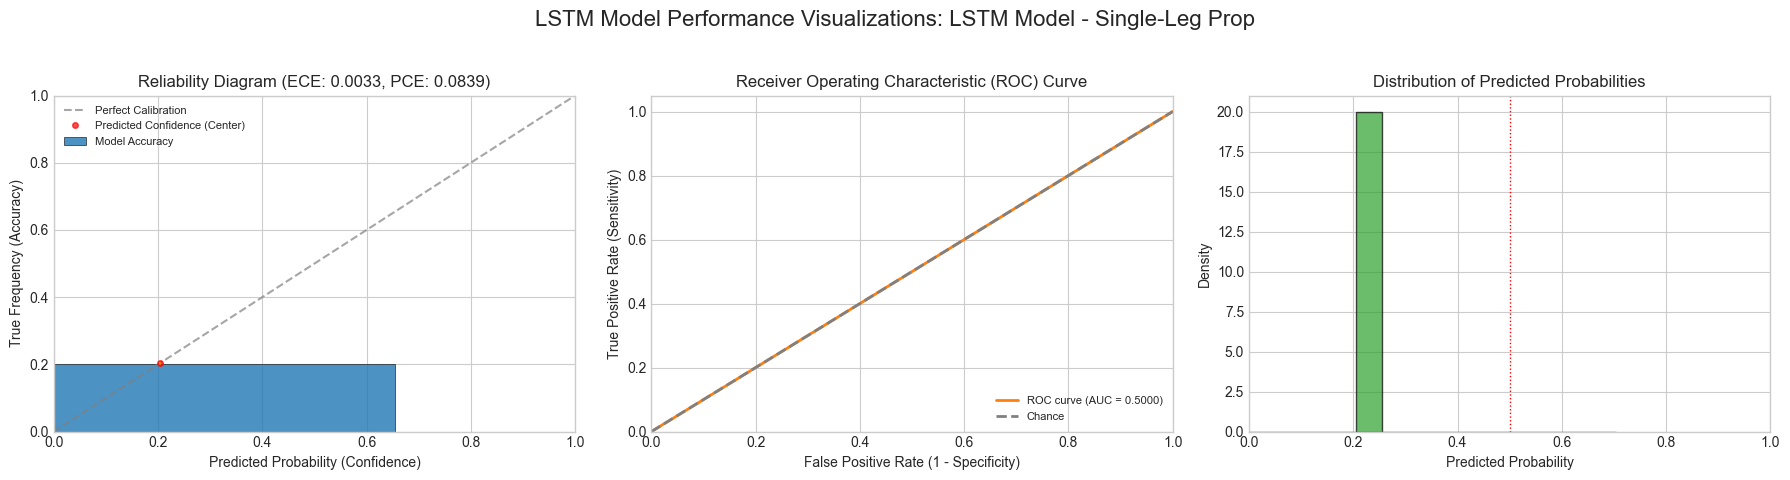

In [17]:
# --- Plotting Function ---
def plot_lstm_metrics_combined(y_true, y_pred_proba, ece, pce, roc_auc, title_suffix):
    """
    Generates three plots (Calibration, ROC, Probability Distribution) 
    in the required 1x3 layout.
    """
    
    bin_data = calculate_ece_bin_data(y_true, y_pred_proba)

    # Use a clean, professional style for comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.style.use('seaborn-v0_8-whitegrid') 

    # --- Plot 1: Reliability Diagram (ECE/PCE) ---
    ax1 = axes[0]
    
    # Plot the diagonal line for perfect calibration
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7, label='Perfect Calibration')

    # Get data from the calculated bin_data
    if not bin_data.empty:
        confidences = bin_data['avg_confidence'].values
        accuracies = bin_data['avg_accuracy'].values
        
        n_bins = len(bin_data)
        bin_width = 1 / n_bins 

        # Plot bars showing actual accuracy
        ax1.bar(confidences, accuracies, width=bin_width * 0.9, color='#1f77b4', alpha=0.8,
                edgecolor='black', linewidth=0.5, label='Model Accuracy')

        # Overlay confidence (center of the bin) as a line or dots to show the gap
        ax1.plot(confidences, confidences, 'o', color='red', alpha=0.7, markersize=4, label='Predicted Confidence (Center)')

        # Add lines connecting the confidence to the actual accuracy
        for c, a in zip(confidences, accuracies):
            ax1.plot([c, c], [c, a], color='orange', linestyle='-', linewidth=1.5, alpha=0.8)


    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('Predicted Probability (Confidence)')
    ax1.set_ylabel('True Frequency (Accuracy)')
    ax1.set_title(f'Reliability Diagram (ECE: {ece:.4f}, PCE: {pce:.4f})', fontsize=12)
    ax1.legend(loc='upper left', fontsize=8)


    # --- Plot 2: ROC Curve (AUC) ---
    ax2 = axes[1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    # roc_auc is passed in, not recalculated
    
    ax2.plot(fpr, tpr, color='C1', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate (1 - Specificity)')
    ax2.set_ylabel('True Positive Rate (Sensitivity)')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=12)
    ax2.legend(loc="lower right", fontsize=8)

    # --- Plot 3: Probability Distribution ---
    ax3 = axes[2]
    ax3.hist(y_pred_proba, bins=20, edgecolor='black', alpha=0.7, color='#2ca02c', density=True)
    ax3.set_xlim(0, 1)
    ax3.set_xlabel('Predicted Probability')
    ax3.set_ylabel('Density')
    ax3.set_title('Distribution of Predicted Probabilities', fontsize=12)

    # Mark the 0.5 decision boundary
    ax3.axvline(0.5, color='red', linestyle=':', linewidth=1)

    plt.suptitle(f"LSTM Model Performance Visualizations: {title_suffix}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

# --- Execution Block ---
try:
    # 1. Retrieve necessary data and calculate AUC
    y_true = results['y_true']
    y_pred_proba = results['hat_p']
    ece = results['ece']
    pce = results['pce']
    
    # Calculate AUC
    from sklearn.metrics import roc_auc_score # Re-import here for robustness
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    print("\n" + "="*55)
    print("        SECTION 16: LSTM MODEL VISUALIZATION        ")
    print("="*55)

    # 2. Generate Plots
    plot_lstm_metrics_combined(
        y_true=y_true,
        y_pred_proba=y_pred_proba,
        ece=ece,
        pce=pce,
        roc_auc=roc_auc,
        title_suffix="LSTM Model - Single-Leg Prop"
    )

except Exception as e:
    print(f"Error during metric saving: {e}")

In [13]:
# --------------------------------------------------------------------
# Metric Saving for Comparison Table
# --------------------------------------------------------------------
try:
    print("\n--- Saving LSTM Metrics for Comparison Table ---")
    
    metrics_folder = 'metrics'
    os.makedirs(metrics_folder, exist_ok=True) 
    file_path = os.path.join(metrics_folder, 'lstm_metrics.json')
    
    lstm_metrics = {
        'ECE': ece,
        'PCE': pce,
        'AUC': roc_auc
    }
    
    with open(file_path, 'w') as f:
        json.dump(lstm_metrics, f, indent=4)
        
    print(f"LSTM metrics (ECE, PCE, AUC) saved to '{file_path}'.")

except Exception as e:
    print(f"Error during metric saving: {e}")


--- Saving LSTM Metrics for Comparison Table ---
LSTM metrics (ECE, PCE, AUC) saved to 'metrics/lstm_metrics.json'.
